<h3 style='color:Blue;'> Packages : </h3>


In [204]:
from random import choice,choices, randint, randrange, random, uniform
from typing import List, Callable, Tuple, Dict
from numpy import mean, array
import time
from Agent import Agent
from tqdm import tqdm
from Simulation import example_simulation
from Obstacle import Obstacle

In [199]:
Chromosome = List[int]
Population = List[Chromosome]
Population_information = List[Dict]
Init_population = Callable[[int,int],Population]
Fitness_function = Callable[[Chromosome],int] #this is a function that asses the validity of our solution
Mutation_operator = Callable[[Chromosome,float],Chromosome]
Crossover_operator = Callable[[Chromosome,Chromosome],Tuple[Chromosome,Chromosome]] #Create off spring Chromosomes 

<h3 style='color:Blue;'> Operations on the population fitness : </h3>


In [226]:
def get_population_informations(population:Population,fitness_function:Fitness_function) -> List[Dict]:
    output = []
    for _ in tqdm(range(len(population)),desc = 'fetching population fitness'): 
        chromosome_information = {'chromosome':population[_],'fitness':fitness_function(population[_])}
        output.append(chromosome_information)
    return output

def sort_population(population_information):
    return sorted(population_information, key=lambda k: k['fitness'])
def population_average(population_information):
    return mean([info['fitness'] for info in population_information])
#this function selects two parents from the population using the roullette wheel selector, the minim
def roulette_wheel_selection(population_information):
    # Computes the totallity of the population fitness
    population_fitness = sum([info['fitness'] for info in population_information])
    # Computes for each chromosome the probability 
    chromosome_probabilities = [info['fitness']/population_fitness for info in population_information]
    chromosome_probabilities = 1 - array(chromosome_probabilities)  
    parents = []
    # Selects two UNIQUE chromosomes based on the computed probabilities
    while len(parents) < 2:
        selection = choices([info['chromosome'] for info in population_information], chromosome_probabilities)[0]
        if selection not in parents:
            parents.append(selection)
    return parents
population_info_sample = [{'chromosome':[1,1,1,1,1],'fitness':30},{'chromosome':[0,0,0,0,0],'fitness':37.5},{'chromosome':[1,0,0,0,0],'fitness':35}]

[{'chromosome': [1, 1, 1, 1, 1], 'fitness': 30}, {'chromosome': [1, 0, 0, 0, 0], 'fitness': 35}, {'chromosome': [0, 0, 0, 0, 0], 'fitness': 37.5}]


<h3 style= 'color:blue' >Evolution Operators:</h3>

In [23]:
#a function used to generate randomly a solution
def generate_chromosome(length: int) -> Chromosome:
    return choices([0, 1], k=length)
#print(generate_chromosome(6))
#this function would be used to intialise a varied initial population
def init_population(size,length) -> Population:
    return [generate_chromosome(length) for _ in range(size)]
#Genetic algorithm configuration:
population_size = 10 
population = init_population(population_size,grid_discretization**2) #case for one obstacle encoding, 64 index ( 8x8 grid)

chromosome_sample = generate_chromosome(grid_discretization**2)

In [214]:
def single_point_crossover(a: Chromosome, b: Chromosome) -> Tuple[Chromosome, Chromosome]:
    length = len(a)
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]
def double_point_crossover(a: Chromosome, b: Chromosome) -> Tuple[Chromosome, Chromosome]:
    length = len(a)
    p1 = randint(1,(length - 1)//2)
    p2 = randint((length - 1)//2,length - 1)
    return a[0:min(p1,p2)]+b[min(p1,p2):max(p1,p2)]+a[max(p1,p2):],b[0:min(p1,p2)]+a[min(p1,p2):max(p1,p2)]+b[max(p1,p2):] 
def mutation_operator(chromosome : Chromosome, p = .1) -> Chromosome:
    if random() <= p:  # Mutation happening with a probability of p
        mutated_gene = randrange(len(chromosome))
        chromosome[mutated_gene] = abs(chromosome[mutated_gene]-1)
        return chromosome
    return chromosome
def fitness_test(chromosome:Chromosome) -> float:
    return len(chromosome)-sum(chromosome) 

<h3 style = 'color:Blue;'> Search space configuration :</h3>

In [242]:
#search spaces Configuration
scene_size = (100,100)
grid_discretization = 6 # these means that the search space would be divided into nxn small blocks 
seach_space_coodinates = (60,30) #the coordinates of the lower_left corner of the search space 
search_space_side = scene_size[0] - seach_space_coodinates[0] - 5
Elementary_obstacles_side =  search_space_side // grid_discretization
print('Search space width :'+str(search_space_side)+'\t Elementary Block width : '+str(Elementary_obstacles_side))



Search space width :35	 Elementary Block width : 5


<h3 style = 'color:Blue;'> Bridging the Multi-agent Model and the GA </h3>

90


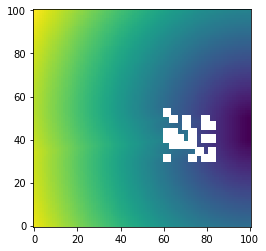

In [236]:
# returns the coordinates of an obstacle given its index 
def evacuation_time(chromosome:Chromosome) -> float:   
    def chromosome_to_obstacles(chromosome:Chromosome) -> List[Obstacle] :
        def index_to_position(index:int,origin_coodinates,n,pas) -> Tuple: 
            O = origin_coodinates
            if index == 0:
                return O
            elif index % n == 0 : 
                (x,y) = (O[0]+(n-1)*pas,O[1]+(index//n -1) * pas )
            else:
                (x,y) = (O[0] + (index % n -1)* pas,O[1] + index//n * pas) #cette formule fonctionne pour tout les tetes sauf pour celle ou le reste est nul raison pour quelle on a ajouté la condition au dessus
            return (x,y)
        obstacles = []
        def fetching_obstacles(chromosome:Chromosome):
            for _ in range(len(chromosome)):
                if chromosome[_] == 1:    
                    position = index_to_position(_,seach_space_coodinates,grid_discretization,Elementary_obstacles_side)
                    side = Elementary_obstacles_side
                    obstacles.append(Obstacle((position),side,side))
            return obstacles
    obstacles = fetching_obstacles(chromosome)
    try:
        return (example_simulation(obstacles)) #this function returns the simulation time
    except:
        #print('something might have been wrong with this configuration')
        return 90 # The simulation breaks for some obstacle's configuration, in case it did the maximum simulation time is to be given  
chromosome_sample = generate_chromosome(grid_discretization**2)
print(fitness_function(chromosome_sample))

<h3 style= 'color:blue' >Evolution Algorithm:</h3>

In [228]:
def Run_evolution() :
    fitness_limit = 0
    fitness = fitness_test
    generation_limit = 100 
    population_size = 50
    population = init_population(population_size,20) #case for one obstacle encoding, 64 index ( 8x8 grid)

    for i in range(generation_limit):
        print('=================================')
        print('Generation Number : ',i)
        population_info = get_population_informations(population,fitness)
        sorted_population = sort_population(population_info)
        print('Minimum fitness is:', sorted_population[0]['fitness'])
        population_avg = population_average(population_info)
        print('Population average is :', population_avg )
        if sorted_population[0]['fitness'] <= fitness_limit:
            break
        
        next_generation = [sorted_population[0]['chromosome']]+[sorted_population[1]['chromosome']] # on garde les deux meilleurs parents pour s'assurer d'avoir  un minimum
        for j in range(int(len(population) / 2) - 1):
            parents = roulette_wheel_selection(population_info)
            offspring_a, offspring_b = double_point_crossover(parents[0], parents[1])
            offspring_a = mutation_operator(offspring_a)
            offspring_b = mutation_operator(offspring_b)
            next_generation += [offspring_a, offspring_b]
        population = next_generation 
        print('=================================')

    return None
Run_evolution()

fetching population fitness: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<?, ?it/s]

Generation Number :  0
Minimum fitness is: 6
Population average is : 9.96
Generation Number :  1
Minimum fitness is: 6
Population average is : 10.14
Generation Number :  2
Minimum fitness is: 6
Population average is : 9.66
Generation Number :  3
Minimum fitness is: 5
Population average is : 9.5
Generation Number :  4
Minimum fitness is: 4
Population average is : 9.02
Generation Number :  5
Minimum fitness is: 4
Population average is : 8.26
Generation Number :  6
Minimum fitness is: 4
Population average is : 8.0
Generation Number :  7
Minimum fitness is: 3
Population average is : 7.16
Generation Number :  8
Minimum fitness is: 3
Population average is : 7.44
Generation Number :  9
Minimum fitness is: 3
Population average is : 7.16
Generation Number :  10
Minimum fitness is: 3
Population average is : 6.9
Generation Number :  11
Minimum fitness is: 3
Population average is : 6.96
Generation Number :  12
Minimum fitness is: 3
Population average is : 6.6
Generation Number :  13
Minimum fitnes


fetching population fitness: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<?, ?it/s]

Minimum fitness is: 1
Population average is : 4.12
Generation Number :  40
Minimum fitness is: 1
Population average is : 4.52
Generation Number :  41
Minimum fitness is: 1
Population average is : 4.76
Generation Number :  42
Minimum fitness is: 1
Population average is : 4.9
Generation Number :  43
Minimum fitness is: 1
Population average is : 4.88
Generation Number :  44
Minimum fitness is: 1
Population average is : 4.94
Generation Number :  45
Minimum fitness is: 1
Population average is : 4.58
Generation Number :  46
Minimum fitness is: 1
Population average is : 4.68
Generation Number :  47
Minimum fitness is: 1
Population average is : 4.68
Generation Number :  48
Minimum fitness is: 1
Population average is : 4.3
Generation Number :  49
Minimum fitness is: 1
Population average is : 3.9
Generation Number :  50
Minimum fitness is: 1
Population average is : 4.12
Generation Number :  51
Minimum fitness is: 1
Population average is : 4.36
Generation Number :  52
Minimum fitness is: 1
Popula